In [3]:
import pandas as pd
import numpy as np
from plotnine import *
import glob
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

In [4]:
categories = [
    {"name": "FTA", "path": "doy_availability/fta_websites.parquet"},
    {"name": "Web User", "path": "doy_availability/outage_report.parquet"},
    {"name": "Cloud User", "path": "doy_availability/cloud_user_reports.parquet"},
    {"name": "Cloud Provider", "path": "doy_availability/cloud_provider_reports.parquet"},
]

In [5]:
all_how_dfs = []
for item in categories:
    dataset_name = item["name"]
    partial_how_df = pd.read_parquet(item["path"])
    if dataset_name == "Web User":
        mask = (partial_how_df["vendor"] == "Instagram") | (partial_how_df["vendor"] == "Netflix") | (partial_how_df["vendor"] == "Gmail")
        partial_how_df = partial_how_df[mask].reset_index(drop=True)
    elif dataset_name == "FTA":
        # www.microsoft.com, www.bbc.co.uk, www.fifa.com
        mask = ((partial_how_df["vendor"] == "www.microsoft.com") 
        | (partial_how_df["vendor"] == "www.bbc.co.uk") 
        | (partial_how_df["vendor"] == "www.fifa.com"))
        partial_how_df = partial_how_df[mask].reset_index(drop=True)
    partial_how_df["name"] = item["name"]
    all_how_dfs.append(partial_how_df)
how_df = pd.concat(all_how_dfs).reset_index(drop=True)
how_df["name"] = pd.Categorical(how_df["name"], ["Cloud Provider", "Cloud User", "Web User", "FTA"])
how_df

,vendor,dayofyear,num_failures,name
0,www.bbc.co.uk,1,10,FTA
1,www.bbc.co.uk,2,12,FTA
2,www.bbc.co.uk,3,8,FTA
3,www.bbc.co.uk,4,10,FTA
4,www.bbc.co.uk,5,6,FTA
...,...,...,...,...
2221,GCP,347,1,Cloud Provider
2222,GCP,349,1,Cloud Provider
2223,GCP,353,5,Cloud Provider
2224,GCP,355,2,Cloud Provider


In [13]:
doy_df = pd.DataFrame({
    "dayofyear": np.tile(np.arange(1, 366, dtype=int), 4),
    "name": np.concatenate([np.repeat("FTA", 365), np.repeat("Web User", 365), np.repeat("Cloud User", 365), np.repeat("Cloud Provider", 365)]),
    "available": np.tile(np.repeat(True, 365), 4)
})
doy_df

,dayofyear,name,available
0,1,FTA,True
1,2,FTA,True
2,3,FTA,True
3,4,FTA,True
4,5,FTA,True
...,...,...,...
1455,361,Cloud Provider,True
1456,362,Cloud Provider,True
1457,363,Cloud Provider,True
1458,364,Cloud Provider,True


In [49]:
how_df["weekofyear"] = how_df["dayofyear"] // 7
weekofyear = how_df.groupby(["name", "weekofyear"])["num_failures"].sum().reset_index()
avail_dfs = []
for dataset in weekofyear["name"].unique():
    partial_df = weekofyear.loc[weekofyear["name"] == dataset, :].reset_index(drop=True)
    partial_df["avail"] = (1 - (partial_df["num_failures"] / partial_df["num_failures"].quantile(0.9))).clip(0, 1)
    avail_dfs.append(partial_df)
avail_df = pd.concat(avail_dfs).reset_index(drop=True)
avail_df

/tmp/ipykernel_8654/1375044029.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,name,weekofyear,num_failures,avail
0,Cloud Provider,0,8,0.753086
1,Cloud Provider,1,15,0.537037
2,Cloud Provider,2,22,0.320988
3,Cloud Provider,3,30,0.074074
4,Cloud Provider,4,22,0.320988
...,...,...,...,...
207,FTA,48,130,0.658613
208,FTA,49,140,0.632353
209,FTA,50,224,0.411765
210,FTA,51,196,0.485294


In [38]:
how_df.loc[how_df["name"] == "Web User", :]

,vendor,dayofyear,num_failures,name
476,Gmail,1,0,Web User
477,Gmail,2,0,Web User
478,Gmail,3,1,Web User
479,Gmail,4,1,Web User
480,Gmail,5,0,Web User
...,...,...,...,...
1566,Instagram,361,10,Web User
1567,Instagram,362,9,Web User
1568,Instagram,363,12,Web User
1569,Instagram,364,10,Web User


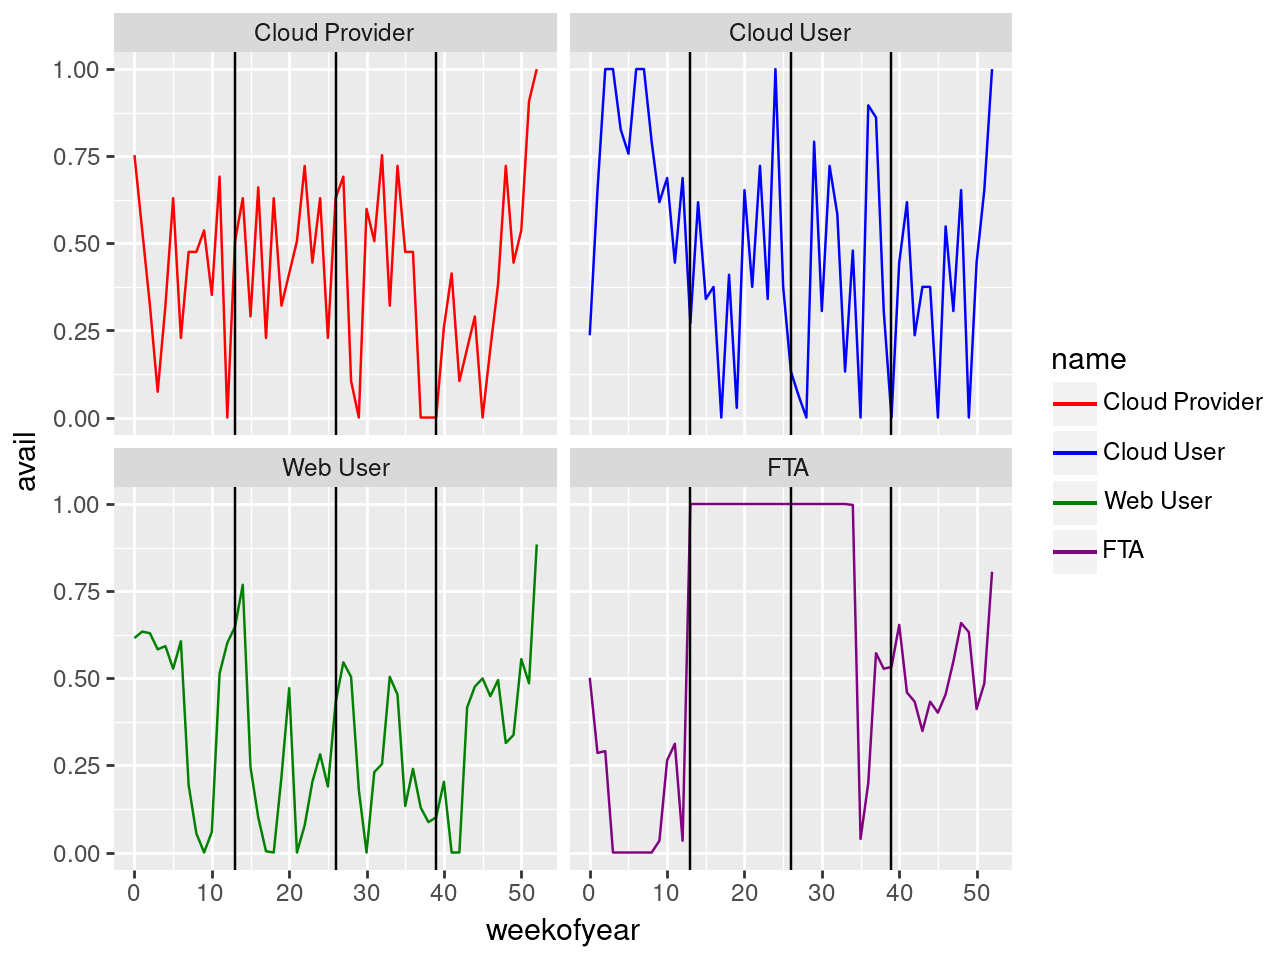

In [58]:
plt = (ggplot(avail_df)
       + geom_line(aes(x="weekofyear", y="avail", color="name", group="name"))
       + scale_color_manual(["red","blue","green","purple"])
       + facet_wrap("name")
       + geom_vline(xintercept=[13, 26, 39])
)

plt